In [1]:
import numpy as np
from collections import defaultdict
from gym import spaces 

import ipywidgets
from ipywidgets import interact
from IPython.display import Image
import IPython

import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
from torch.distributions import Categorical

from rllib.environment.mdps import EasyGridWorld
from rllib.policy import TabularPolicy
from rllib.value_function import TabularQFunction, TabularValueFunction
from rllib.util.neural_networks.utilities import one_hot_encode
from matplotlib import rcParams
import copy 

import warnings
warnings.filterwarnings("ignore")

rcParams['font.size'] = 12

rcParams['figure.figsize'] = (20, 8)

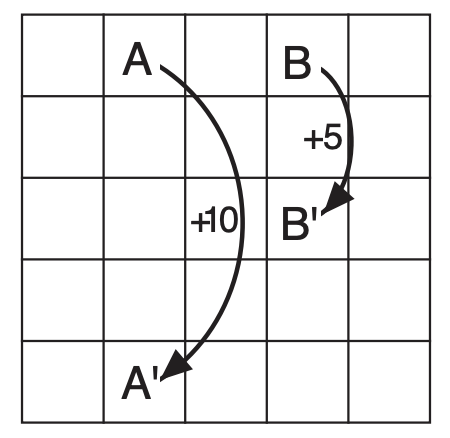

In [2]:
def extract_policy(q_function):
    """Extract a policy from the q_function."""
    policy = TabularPolicy(num_states=q_function.num_states, num_actions=q_function.num_actions)
    for state in range(policy.num_states):
        q_val = q_function(torch.tensor(state).long())
        action = torch.argmax(q_val)
        
        policy.set_value(state, action)
    
    return policy 

def plan_policy(state, environment, value_function, gamma):
    next_value = torch.zeros(environment.num_actions)  # value of taking the different actions.
    for action in range(environment.num_actions):
        value_estimate = 0

        # In practice, we do not have access to environment.transitions, but only to samples of it!.
        for transition in environment.transitions[(state, action)]:  
            next_state = torch.tensor(transition["next_state"]).long()
            reward = torch.tensor(transition["reward"]).double()
            value_estimate += transition["probability"] * (
                reward + gamma * value_function(next_state)
            )
            
        next_value[action] = value_estimate
    policy = torch.where(next_value == torch.max(next_value))[0]
    
    return policy 

def integrate_q(q_function, policy):
    value_function = TabularValueFunction(num_states = q_function.num_states)
    for state in range(policy.num_states):
        state = torch.tensor(state).long()
        pi = Categorical(logits=policy(state))
        value = 0
        for action in range(policy.num_actions):
            value += pi.probs[action] * q_function(state, torch.tensor(action).long())
        
        value_function.set_value(state, value)
    
    return value_function

# Planning 
def init_value_function(num_states, terminal_states=None):
    """Initialize value function."""
    value_function = TabularValueFunction(num_states=num_states)
    terminal_states = [] if terminal_states is None else terminal_states
    for terminal_state in terminal_states:
        value_function.set_value(terminal_state, 0)

    return value_function

# Plotters
def policy2str(policy):
    if len(policy) == 4:
        return "*"
    
    left = u'\u2190'
    right = u'\u2192'
    up = u'\u2191'
    down = u'\u2193'
    policy_str = ""
    if 0 in policy:
        policy_str += down 
    if 1 in policy:
        policy_str += up 
    if 2 in policy:
        policy_str += right
    if 3 in policy:
        policy_str += left
    return policy_str

def plot_value_function(value_function, ax):
    ax.imshow(value_function)
    rows, cols = value_function.shape
    for row in range(rows):
        for col in range(cols):
            ax.text(row, col, f"{value_function[col, row]:.1f}", ha="center", va="center", color="w", fontsize=24)

def plot_policy(policy, environment, ax):
    ax.imshow(np.zeros((environment.height, environment.width)))
    for row in range(environment.height):
        for col in range(environment.width):
            policy_ = policy(torch.tensor(row * environment.width + col))
            ax.text(col, row, policy2str(policy_), ha="center", va="center", color="r", fontsize=24)

def plot_induced_policy(environment, value_function, gamma, ax):
    ax.imshow(np.zeros((environment.height, environment.width)))
    for row in range(environment.height):
        for col in range(environment.width):
            policy_ = plan_policy(row * environment.width + col, environment, value_function, gamma)
            ax.text(col, row, policy2str(policy_), ha="center", va="center", color="r", fontsize=24)
            
def plot_value_and_policy(value_function, policy):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))
    
    plot_value_function(value_function, axes[0]) 

environment = EasyGridWorld()
Image("images/grid_world.png")

### Grid world Example 
#### Some explanation
In this Markov Decision Processes the set of states are the (5x5) grid posions in which the agent can be located.
The set of actions consists of: moving up, down, left, and right. 

The transition noise probability $\delta$ corresponds to the probability with which the agent remains in the current state (i.e., does not move). With probabiliuty $1-\delta$ the action is properly exectued an the agent moves to the adjacend grid cell indivated by the action, unless it hits a wall, in which case the agent remains in its current cell.

This is a spare reward MDP. The agent will get a reward of +10 if it enters grid cell A and moves to A' regardless of the action. Similarly, the agent will get a +5 reward if it enters grid cell B and will be transferred to B'.
If the agent bumps against the wall, it will get a reward of -1.

For more details and derivation of MDPs you can check the [work](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) of Sutton and Barto. Page 72, Example 3.8: Gridworld.


# Policy Evaluation

In [3]:
def policy_evaluation_step(environment, policy, value_function, gamma, gauss_seidel=False):
    max_error = 0
    avg_error = 0
    if gauss_seidel:
        old_value_function = value_function
    else:
        
        old_value_function = copy.deepcopy(value_function)
    for state in range(environment.num_states):
        if state in environment.terminal_states:
            continue

        value_estimate = torch.tensor(0.0)
        state = torch.tensor(state).long()
        policy_ = Categorical(logits=policy(state))

        for action in np.where(policy_.probs.detach().numpy())[0]:
            p_action = policy_.probs[action].item()

            # In RL, we do not have access to environment.transitions, but only to samples of it!.
            for transition in environment.transitions[(state.item(), action)]:
                next_state = torch.tensor(transition["next_state"]).long()
                value_estimate += (
                    p_action
                    * transition["probability"]
                    * (transition["reward"] + gamma * old_value_function(next_state).item())
                )

        value = value_function(state)
        error = torch.abs(value_estimate - value).item()
        max_error = max(max_error, error)
        avg_error += error
        value_function.set_value(state, value_estimate)
    return max_error 

def iterative_policy_evaluation(environment, policy, gamma, eps=1e-6, max_iter=1000, gauss_seidel=False, value_function=None):
    """Implement Policy Evaluation algorithm (policy iteration without max).

    Parameters
    ----------
    policy: TabularPolicy
    gamma: float
        discount factor.
    eps: float 
        desired precision.
    max_iter: int 
        Max number of iterations. 
    value_function: TabularValueFunction, optional. 
        Initial value function. 
        
    Returns
    -------
    value_function: TabularValueFunction
        Value function associated to Policy.
    num_iter: int
        Number of iterations to reach `eps' accuracy. 

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.1

    """
    if value_function is None:
        value_function = init_value_function(environment.num_states)
    for num_iter in range(max_iter):
        max_error = policy_evaluation_step(environment, policy, value_function, gamma, gauss_seidel=gauss_seidel)

        if max_error < eps:
            break
    return value_function, num_iter

def pe_interact(gamma, noise, gauss_seidel):
    output = ipywidgets.Output()
    environment = EasyGridWorld(noise=noise)
    value_function = init_value_function(environment.num_states)
    policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    def plot_algorithm():
        with output:
            output.clear_output()
            fig, ax = plt.subplots(ncols=2)
            plot_policy(policy, environment, ax[1])
            ax[1].set_title("Evaluated Policy")

            plot_value_function(value_function.table.reshape(5, 5).detach().numpy(), ax[0])
            ax[0].set_title("Value Function")

            plt.show()
        
    def step():
        max_error = policy_evaluation_step(environment, policy, value_function, gamma, gauss_seidel=gauss_seidel) 
        plot_algorithm()
        print(f"Max Bellman Error {max_error}")
        
    plot_algorithm()
    button = ipywidgets.Button(description="Step")
    button.on_click(lambda b: step())
    display(button, output)
    
    
interact(
    pe_interact,
    gamma=ipywidgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.9, continuous_update=False),
    noise=ipywidgets.FloatSlider(min=0, max=0.9, step=0.01, value=0, continuous_update=False),
    gauss_seidel=False
);


interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='gamma', max=0.99, step=0.01…

## Demo Guide:

#### some explanation
This demo above implement the policy evaluation on the gridworld. It means now given the policy we will calculate the long-term value using fixed point iteration. Note that current policy is randomly move to up, down, left or right.
- gamma: Discount factor 
- noise: When noise > 0, then transitions happen with probability = 1-noise.
    With probability noise the agent stays at the current state.
- gauss_seidel: Method of successive displacement, more details could be checked [here](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method).

#### play around
- Do the fixed point iteration yourself on some grid and compare the results
- Play around with different noise and see the differences
- Use the gauss_seidel and see the difference


In [4]:
def build_mrp_matrices(environment, policy):
    mrp_kernel = np.zeros((environment.num_states, 1, environment.num_states))
    mrp_reward = np.zeros((environment.num_states, 1))

    for state in range(environment.num_states):
        if state in environment.terminal_states:
            mrp_kernel[state, 0, state] = 1
            mrp_reward[state] = 0
            continue

        state = torch.tensor(state).long()
        policy_ = Categorical(logits=policy(state))

        for a, p_action in enumerate(policy_.probs):
            for transition in environment.transitions[(state.item(), a)]:
                with torch.no_grad():
                    p_ns = transition["probability"]
                    mrp_reward[state, 0] += p_action * p_ns * transition["reward"]
                    mrp_kernel[state, 0, transition["next_state"]] += p_action * p_ns
    
    return mrp_kernel, mrp_reward


def average_policy_evaluation(environment, policy, value_function=None):
    r"""Evaluate policy.

    Finds stationary distribution (right eigenvector of 1 eigenvalue) and computes
    ..math:: \langle \mu, r \rangle.

    """
    if value_function is None:
        value_function = init_value_function(environment.num_states)
        
    kernel, reward = build_mrp_matrices(environment=environment, policy=policy)
    eig_values, eig_vectors = np.linalg.eig(kernel[:, 0, :].T)
    idx = np.where(np.isclose(eig_values, 1))[0]
    stationary_distirbution = eig_vectors[:, idx] / eig_vectors[:, idx].sum()
    average_reward = torch.tensor(np.real(reward.T @ stationary_distirbution)).float()[0, 0].item()
    
    new_reward = reward[:, 0] - average_reward
    V = np.zeros(environment.num_states)
    for i in range(1000):
        V = new_reward + kernel[:, 0] @ V
        V -= V.mean()

    for state in range(value_function.num_states):
        value_function.set_value(state, V[state])
    
    return value_function 

def linear_system_policy_evaluation(environment, policy, gamma, value_function=None):
    """Evaluate a policy in an MDP solving the system bellman of equations.

    V = r + gamma * P * V
    V = (I - gamma * P)^-1 r
    """
    if gamma == 1:
        return average_policy_evaluation(environment, policy)
    
    if value_function is None:
        value_function = init_value_function(environment.num_states)

    kernel, reward = build_mrp_matrices(environment=environment, policy=policy)

    A = torch.eye(environment.num_states) - gamma * kernel[:, 0, :]
    # torch.testing.assert_allclose(A.inverse() @ A, torch.eye(model.num_states))
    vals = A.inverse() @ reward[:, 0]
    for state in range(environment.num_states):
        value_function.set_value(state, vals[state].item())

    return value_function


# Value iteration

In [5]:
def value_iteration_step(environment, policy, value_function, gamma, gauss_seidel=False):
    error = 0
    if gauss_seidel:
        old_value_function = value_function
    else:
        old_value_function = copy.deepcopy(value_function)
    for state in range(environment.num_states):
        value_ = torch.zeros(environment.num_actions)  # value of taking the different actions.
        for action in range(environment.num_actions):
            value_estimate = 0

            # In practice, we do not have access to environment.transitions, but only to samples of it!.
            for transition in environment.transitions[(state, action)]:  
                next_state = torch.tensor(transition["next_state"]).long()
                reward = torch.tensor(transition["reward"]).double()
                value_estimate += transition["probability"] * (
                    reward + gamma * old_value_function(next_state)
                )
            value_[action] = value_estimate
        state = torch.tensor(state).long()
        value = value_function(state)
        value_, action = torch.max(value_, 0)

        error = max(error, torch.abs(value_ - value.item()))
        value_function.set_value(state, value_)
        policy.set_value(state, action)
    return error 

def value_iteration(environment, gamma, eps=1e-6, max_iter=1000, gauss_seidel=False, value_function=None, policy=None):
    """Implement of Value Iteration algorithm.

    Parameters
    ----------
    gamma: float
        discount factor.
    eps: float 
        desired precision.
    max_iter: int 
        Max number of iterations. 
    value_function: TabularValueFunction, optional. 
        Initial value function. 
        
    Returns
    -------
    value_function: TabularValueFunction
        Optimal value function.
    policy: Tabular Policy 
        Optimal policy. 
    num_iter: int
        Number of iterations to reach `eps' accuracy. 

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.4

    """
    if value_function is None:
        value_function = init_value_function(environment.num_states)
    if policy is None:
        policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    for num_iter in range(max_iter):
        error = value_iteration_step(environment, policy, value_function, gamma, gauss_seidel=gauss_seidel)

        if error < eps:
            break

    return value_function, policy, num_iter 



def vi_interact(gamma, noise, gauss_seidel):
    output = ipywidgets.Output()
    environment = EasyGridWorld(noise=noise)
    value_function = init_value_function(environment.num_states)
    policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    def plot_algorithm():
        with output:
            output.clear_output()
            fig, ax = plt.subplots(ncols=2)
            plot_induced_policy(environment, value_function, gamma, ax[1])
            ax[1].set_title("Induced Policy")

            plot_value_function(value_function.table.reshape(5, 5).detach().numpy(), ax[0])
            ax[0].set_title("Value Function")

            plt.show()
        
    def step(b):
        max_error = value_iteration_step(environment, policy, value_function, gamma, gauss_seidel=gauss_seidel) 
        plot_algorithm()
        print(f"Max Bellman Error {max_error}")
        
    plot_algorithm()
    button = ipywidgets.Button(description="Step")
    button.on_click(step)
    display(button, output)
    
    
interact(
    vi_interact,
    gamma=ipywidgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.9, continuous_update=False),
    noise=ipywidgets.FloatSlider(min=0, max=0.9, step=0.01, value=0, continuous_update=False),
    gauss_seidel=False
);


interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='gamma', max=0.99, step=0.01…

## Demo Guide:

#### some explanation
This demo above implement the value iteration on the gridworld. It compute the Q value for all states action pairs and choose the geedy policy for the states until the convergence.
- gamma:Discount factor 
- noise: When noise > 0, then transitions happen with probability = 1-noise.
    With probability noise the agent stays at the current state.
- gauss_seidel: Method of successive displacement, more details could be checked [here](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method).

#### play around
- Do the value yourself on some grid and compare the results
- Play around with different noise and see the differences
- Use the gauss_seidel and see the difference


# Policy Iteration

In [8]:
def policy_iteration_step(environment, policy, value_function, gamma):
    value_function = linear_system_policy_evaluation(environment, policy, gamma)
    policy_stable = True
    for state in range(environment.num_states):

        value_ = torch.zeros(environment.num_actions)
        for action in range(environment.num_actions):
            value_estimate = 0
            for transition in environment.transitions[(state, action)]:
                next_state = torch.tensor(transition["next_state"]).long()
                reward = torch.tensor(transition["reward"]).double()
                value_estimate += transition["probability"] * (
                    reward + gamma * value_function(next_state).item()
                )

            value_[action] = value_estimate

        state = torch.tensor(state).long()
        old_policy = policy(state)
        old_action = torch.argmax(old_policy)

        action = torch.argmax(value_)
        policy.set_value(state, action)

        policy_stable &= (action == old_action).all().item()
    
    return value_function, policy_stable 


def policy_iteration(environment, gamma, max_iter=10, value_function=None, policy=None):
    """Implement Policy Iteration algorithm.

    Parameters
    ----------
    gamma: float.
        discount factor.

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.3

    """
    if value_function is None:
        value_function = init_value_function(environment.num_states)
    if policy is None:
        policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    for num_iter in range(max_iter):
        # Evaluate the policy. 
        value_function, policy_stable = policy_iteration_step(environment, policy, value_function, gamma)
        
        if policy_stable:
            break
    return value_function, policy, num_iter


def pi_interact(gamma, noise):
    output = ipywidgets.Output()
    environment = EasyGridWorld(noise=noise)
    value_function = init_value_function(environment.num_states)
    policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)

    def plot_algorithm(val_func):
        with output:
            output.clear_output()
            fig, ax = plt.subplots(ncols=2)
            plot_induced_policy(environment, val_func, gamma, ax[1])
            ax[1].set_title("Induced Policy")

            plot_value_function(val_func.table.reshape(5, 5).detach().numpy(), ax[0])
            ax[0].set_title("Value Function")

            plt.show()
        
    def step(value_function):
        value_function, policy_stable = policy_iteration_step(environment, policy, value_function, gamma)
        plot_algorithm(value_function)
        print(f"Did the policy change? {'No' if policy_stable else 'Yes'}")
        
    plot_algorithm(value_function)
    button = ipywidgets.Button(description="Step")
    button.on_click(lambda b: step(value_function))
    display(button, output)
    
    
interact(
    pi_interact,
    gamma=ipywidgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.9, continuous_update=False),
    noise=ipywidgets.FloatSlider(min=0, max=0.9, step=0.01, value=0, continuous_update=False)
);



interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='gamma', max=0.99, step=0.01…

## Demo Guide:

#### some explanation
This demo above implement the policy iteration on the gridworld. It starts with arbitrary policy and compute the value function iteratively and update the policy based on greedy algorithm 
- gamma:Discount factor 
- noise: When noise > 0, then transitions happen with probability = 1-noise.
    With probability noise the agent stays at the current state.
- gauss_seidel: Method of successive displacement, more details could be checked [here](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method).

#### play around
- Do the policy iteration yourself on some grid and compare the results
- Play around with different noise and see the differences
- Compare with the value iteration above. Which one performs better in this demo?


In [7]:
def algorithm_interact(name, gamma, noise, eps, gauss_seidel):
    environment = EasyGridWorld(noise=noise)
    IPython.display.clear_output(wait=True)
    plt.close()
        
    fig, ax = plt.subplots(ncols=2)

    if name == "Iterative Policy Evaluation":
        policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)
        value_function, num_iter = iterative_policy_evaluation(environment, policy, gamma, max_iter=1000, eps=eps, gauss_seidel=gauss_seidel) 
        plot_policy(policy, environment, ax[1])
        ax[1].set_title("Evaluated Policy")

    elif name == "Linear System Policy Evaluation":
        policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)
        value_function = linear_system_policy_evaluation(environment, policy, gamma)
        num_iter = 1
        plot_policy(policy, environment, ax[1])
        ax[1].set_title("Evaluated Policy")

    elif name == "Value Iteration": 
        value_function, policy, num_iter = value_iteration(environment, gamma, eps=eps, gauss_seidel=gauss_seidel) 
        plot_induced_policy(environment, value_function, gamma, ax[1])
        ax[1].set_title("Extracted Policy")

    elif name == "Policy Iteration": 
        value_function, policy, num_iter =  policy_iteration(environment, gamma)
        plot_induced_policy(environment, value_function, gamma, ax[1])
        ax[1].set_title("Extracted Policy")

    print(f"Converged after {num_iter} {'iterations' if num_iter > 1 else 'iteration'}.")

    plot_value_function(value_function.table.reshape(5, 5).detach().numpy(), ax[0])
    ax[0].set_title("Value Function")
    plt.show()
    
interact(
    algorithm_interact,
    name=["Value Iteration", "Policy Iteration", "Linear System Policy Evaluation", "Iterative Policy Evaluation"],
    gamma=ipywidgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.9, continuous_update=False),
    noise=ipywidgets.FloatSlider(min=0, max=0.9, step=0.01, value=0, continuous_update=False),
    eps=ipywidgets.FloatLogSlider(min=-6, max=-1, step=0.01, value=1e-3, continuous_update=False),
    gauss_seidel=False
);

interactive(children=(Dropdown(description='name', options=('Value Iteration', 'Policy Iteration', 'Linear Sys…

## Demo Guide:

#### some explanation
This demo provides 4 different method to help you understand the policy iteration and value iterations. Note that the first two method will converge to the optimal policy and correspondent value function, showing the iterations need for convergence. While the third and fourth methods are just policy evaluation method given the fixed policy.
- gamma:Discount factor 
- noise: When noise > 0, then transitions happen with probability = 1-noise.
    With probability noise the agent stays at the current state.
- eps: desired precision for value iterations.
- gauss_seidel: Method of successive displacement, more details could be checked [here](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method).

#### play around
- Compre the iterations needed for convergence between policy iterations and value iterations. Which one is faster and why?
- Change the desired precision and see the difference of iterations needed for convergence.
- Compare with the iterate policy evaluation and linear system policy iterations. which one is faster in this demo? What happened if we have more states or more action options?
